In [ ]:
# Import libraries
import torch
import matplotlib.pyplot as plt
import numpy as np
from train import NeuralNet, image_size  # import your CNN class
from PIL import Image
import os

In [ ]:
# Paths to sample images/masks
img_path = "data/sample_images/"
mask_path = "data/sample_masks/"

sample_imgs = sorted([f for f in os.listdir(img_path) if f.endswith(".png")])
sample_masks = sorted([f for f in os.listdir(mask_path) if f.endswith(".png")])

print("Images:", len(sample_imgs))
print("Masks:", len(sample_masks))

print(sample_imgs)
print(sample_masks)

# Load images as numpy arrays
x_sample = []
y_sample = []

for i in range(len(sample_imgs)):
    img = np.array(Image.open(os.path.join(img_path, sample_imgs[i])).resize((image_size, image_size)))
    mask = np.array(Image.open(os.path.join(mask_path, sample_masks[i])).resize((image_size, image_size)))
    # normalize images to 0-1
    img = img / 255.0
    mask = (mask > 0).astype(np.float32)

    x_sample.append(img)
    y_sample.append(mask)

x_sample = np.array(x_sample)
y_sample = np.array(y_sample)




Images: 6
Masks: 6
['image-0.png', 'image-1.png', 'image-2.png', 'image-3.png', 'image-4.png', 'image-5.png']
['mask-0.png', 'mask-1.png', 'mask-2.png', 'mask-3.png', 'mask-4.png', 'mask-5.png']


In [ ]:
# Draw function (for visualization)
def draw(image, mask):
    plt.figure(figsize=(4,2))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Original Image")

    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title("Mask / Prediction")
    plt.show()


In [ ]:
# Load model and make predictions on CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNet().to(device)

# If no GPU, map model to CPU
model.load_state_dict(torch.load("best_model.pth", map_location=device))

# Convert sample images to tensor
x_tensor = torch.tensor(x_sample, dtype=torch.float32).view(-1, image_size, image_size, 3).permute(0,3,1,2).to(device)
ypred = model.predict(x_tensor)


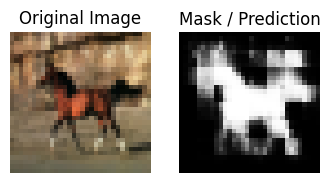

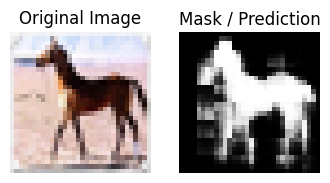

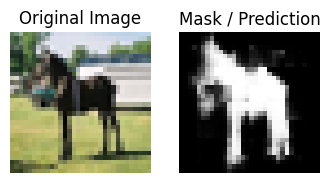

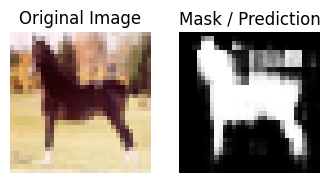

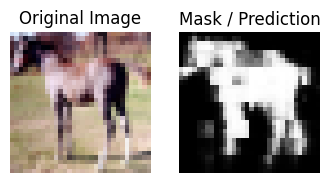

In [ ]:
# Visualize sample predictions
for i in range(min(5, len(x_sample))):
    mask_pred = ypred[i].reshape(image_size, image_size)  # reshape 1D -> 2D
    draw(x_sample[i], mask_pred)


In [ ]:
# IOU function
def iou(ytrue, yprediction):
    yp = yprediction
    yt = ytrue
    yp = yp > 0.5 + 0  # convert probabilities to binary mask
    intersect = np.sum(np.minimum(yp, yt))
    union = np.sum(np.maximum(yp, yt))
    return intersect / (union + 1e-8)  # 避免除以 0


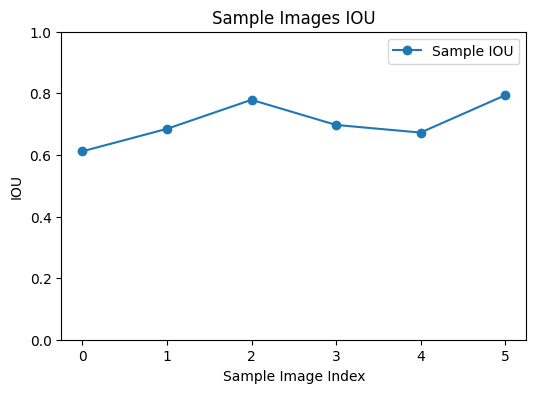

In [ ]:
# Loss / IOU curves for sample images
import matplotlib.pyplot as plt
import numpy as np

# Compute IOU for each sample image
sample_iou = [iou(y_sample[i], ypred[i].reshape(image_size, image_size)) for i in range(len(x_sample))]

# Plot IOU per sample image
plt.figure(figsize=(6,4))
plt.plot(range(len(sample_iou)), sample_iou, marker='o', label="Sample IOU")
plt.xlabel("Sample Image Index")
plt.ylabel("IOU")
plt.title("Sample Images IOU")
plt.ylim(0, 1)
plt.legend()
plt.show()